Načtené hodnoty: scale=1.6251, offset=-3946


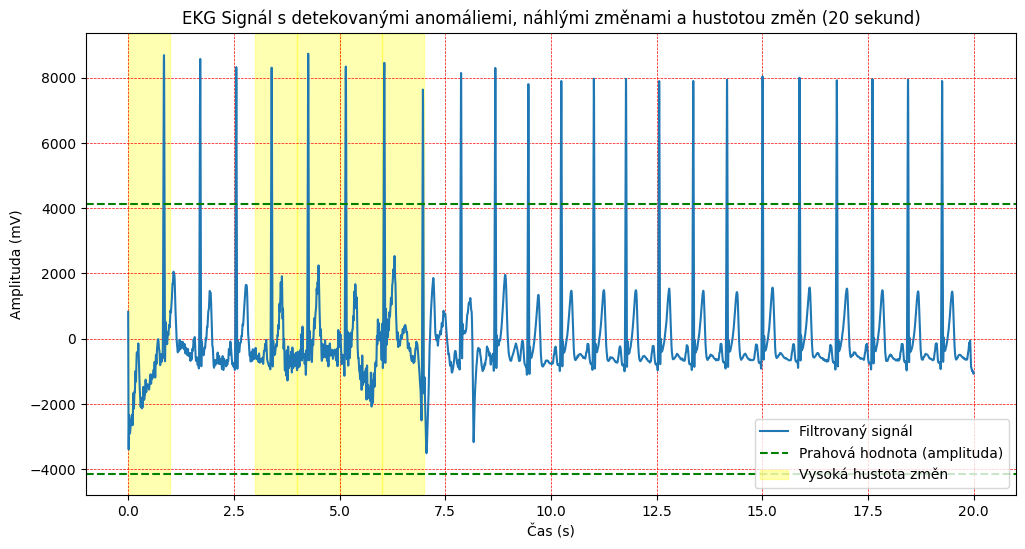

Počet detekovaných anomálií v prvních 20 sekundách: 550
Počet detekovaných náhlých změn v prvních 20 sekundách: 229


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Funkce pro načtení metadat ze souboru .hea
def load_header(hea_file):
    with open(hea_file, "r") as f:
        lines = f.readlines()
    scale, offset = None, None
    for line in lines:
        if ".dat" in line:
            parts = line.split()
            if len(parts) >= 3:
                scale = float(parts[2].split("(")[0])
                offset = int(parts[2].split("(")[1].split(")")[0])
            break
    if scale is None or offset is None:
        raise ValueError(f"Nelze načíst scale nebo offset ze souboru {hea_file}.")
    return scale, offset

# Funkce pro načtení EKG signálu
def load_ecg_signal(dat_file, scale, offset, dtype=np.int16):
    with open(dat_file, "rb") as f:
        raw_signal = np.fromfile(f, dtype=dtype)
    return (raw_signal + offset) * scale

# Funkce pro aplikaci pásmového filtru
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Funkce pro detekci anomálií na základě prahové hodnoty
def detect_anomalies(signal, threshold):
    anomalies = np.where(np.abs(signal) > threshold)[0]
    return anomalies

# Funkce pro výpočet průměrné amplitudy signálu v časových oknech
def compute_average_amplitude(signal, fs, window_size=1):
    samples_per_window = fs * window_size
    avg_amplitude = [np.mean(np.abs(signal[i:i + samples_per_window]))
                     for i in range(0, len(signal), samples_per_window)]
    return np.array(avg_amplitude)

# Funkce pro detekci náhlých změn v signálu (pohybové artefakty)
def detect_sudden_changes(signal, threshold):
    diff_signal = np.diff(signal)  # Rozdíl mezi sousedními vzorky
    sudden_changes = np.where(np.abs(diff_signal) > threshold)[0]
    return sudden_changes

# Funkce pro detekci zahuštění signálu (lokální hustota změn)
def detect_signal_density(signal, fs, window_size=1):
    samples_per_window = fs * window_size
    density = [np.sum(np.abs(np.diff(signal[i:i + samples_per_window])))
               for i in range(0, len(signal), samples_per_window)]
    return np.array(density)

# Parametry
hea_file = "brno-university-of-technology/103001/103001_ECG.hea"
dat_file = "brno-university-of-technology/103001/103001_ECG.dat"
fs = 1000  # Vzorkovací frekvence (Hz)
lowcut = 0.5  # Dolní mez pásmového filtru (Hz)
highcut = 40.0  # Horní mez pásmového filtru (Hz)
duration = 20  # Délka signálu pro vykreslení (v sekundách)

# Načtení metadat ze souboru .hea
scale, offset = load_header(hea_file)
print(f"Načtené hodnoty: scale={scale}, offset={offset}")

# Načtení EKG signálu ze souboru .dat
ec_signal = load_ecg_signal(dat_file, scale, offset)

# Aplikace pásmového filtru
filtered_signal = bandpass_filter(ec_signal, lowcut, highcut, fs)

# Detekce anomálií
threshold = 3 * np.std(filtered_signal)  # Prahová hodnota (3x standardní odchylka)
anomalies = detect_anomalies(filtered_signal, threshold)

# Detekce náhlých změn
sudden_change_threshold = 5 * np.std(np.diff(filtered_signal))  # Prahová hodnota pro náhlé změny
sudden_changes = detect_sudden_changes(filtered_signal, sudden_change_threshold)

# Detekce zahuštění signálu
density = detect_signal_density(filtered_signal, fs)
time_density = np.arange(len(density))  # 1 hodnota za sekundu

# Výpočet času
time = np.arange(len(filtered_signal)) / fs

# Výběr pouze prvních duration sekund
end_idx = duration * fs
filtered_signal_60s = filtered_signal[:end_idx]
anomalies_60s = anomalies[anomalies < end_idx]
sudden_changes_60s = sudden_changes[sudden_changes < end_idx]
time_60s = time[:end_idx]
density_60s = density[:duration]

# Výpočet průměrné amplitudy
avg_amplitude = compute_average_amplitude(filtered_signal_60s, fs)
time_avg = np.arange(len(avg_amplitude))  # 1 hodnota za sekundu

# Vykreslení signálu s anomáliemi, náhlými změnami a zvýrazněnými zahuštěnými oblastmi
plt.figure(figsize=(12, 6))
plt.plot(time_60s, filtered_signal_60s, label="Filtrovaný signál")
plt.axhline(y=threshold, color="green", linestyle="--", label="Prahová hodnota (amplituda)")
plt.axhline(y=-threshold, color="green", linestyle="--")

# Zvýraznění zahuštěných oblastí pouze pro 20 sekund
high_density_threshold = np.percentile(density_60s, 75)  # Práh pro vysokou hustotu změn
for i, d in enumerate(density_60s):
    if d > high_density_threshold:
        plt.axvspan(i, i + 1, color='yellow', alpha=0.3, label="Vysoká hustota změn" if i == 0 else None)

plt.title("EKG Signál s detekovanými anomáliemi, náhlými změnami a hustotou změn (20 sekund)")
plt.xlabel("Čas (s)")
plt.ylabel("Amplituda (mV)")
plt.grid(color='red', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Statistika anomálií
num_anomalies = len(anomalies_60s)
num_sudden_changes = len(sudden_changes_60s)
print(f"Počet detekovaných anomálií v prvních {duration} sekundách: {num_anomalies}")
print(f"Počet detekovaných náhlých změn v prvních {duration} sekundách: {num_sudden_changes}")



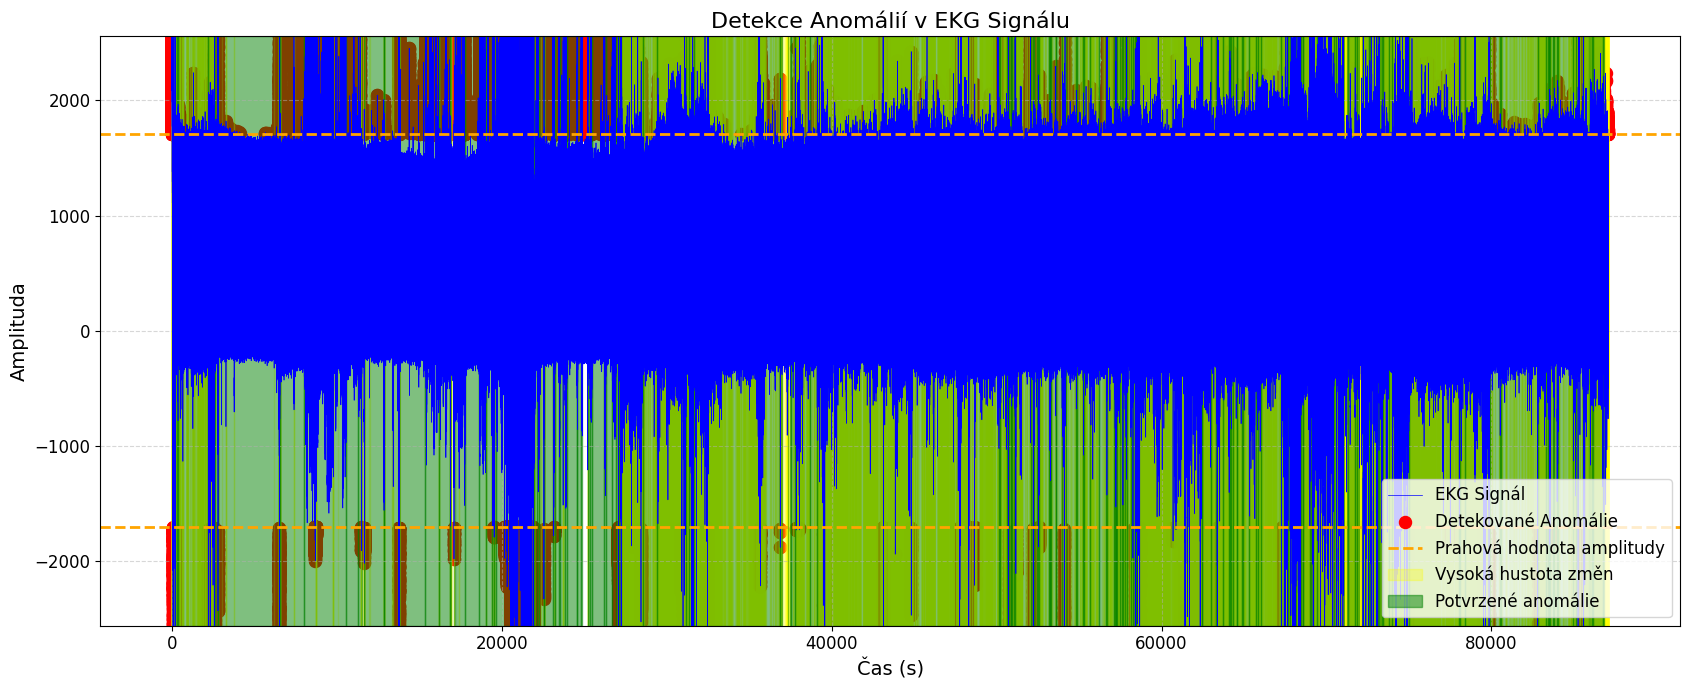

In [8]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detect_anomalies_amplitude(signal):
    mean_amplitude = np.mean(signal)
    std_amplitude = np.std(signal)
    
    # Dynamické prahování
    threshold_amplitude = mean_amplitude + 3.7 * std_amplitude
    anomalies = np.where(np.abs(signal) > threshold_amplitude)[0]
    
    return anomalies, threshold_amplitude

# Funkce pro výpočet průměrné amplitudy signálu v časových oknech
def compute_average_amplitude(signal, sampling_rate, window_size=1):
    samples_per_window = sampling_rate * window_size
    avg_amplitude = [np.mean(np.abs(signal[i:i + samples_per_window]))
                     for i in range(0, len(signal), samples_per_window)]
    return np.array(avg_amplitude)

# Funkce pro detekci hustoty změn signálu
def detect_signal_density(signal, sampling_rate, window_size=1):
    samples_per_window = sampling_rate * window_size
    density = [np.sum(np.abs(np.diff(signal[i:i + samples_per_window])))
               for i in range(0, len(signal), samples_per_window)]
    return np.array(density)

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        signal = record.p_signal[:, 0]

        # Detekce anomálií na základě amplitudy
        anomalies, threshold_amplitude = detect_anomalies_amplitude(signal)

        signal -= np.mean(signal)

        annotations = pd.read_csv(ann_path, header=None)
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < signal_length) & (annotation_end < signal_length)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        # Výpočet průměrné amplitudy
        avg_amplitude = compute_average_amplitude(signal, sampling_rate)

        # Detekce hustoty změn signálu
        density = detect_signal_density(signal, sampling_rate)
        high_density_threshold = np.percentile(density, 75)

        time = np.arange(len(signal)) / sampling_rate
        plt.figure(figsize=(17, 7))
        plt.plot(time, signal, label='EKG Signál', color='blue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(time[anomalies], signal[anomalies], color='red', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahové hodnoty
        plt.axhline(y=threshold_amplitude, color='orange', linestyle='--', linewidth=2, label='Prahová hodnota amplitudy')
        plt.axhline(y=-threshold_amplitude, color='orange', linestyle='--', linewidth=2)

        # Zvýraznění hustoty změn
        for i, d in enumerate(density):
            if d > high_density_threshold:
                plt.axvspan(i, i + 1, color='yellow', alpha=0.3, label='Vysoká hustota změn' if i == 0 else None)

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for start, end in zip(annotation_start, annotation_end):
            matching_anomalies = [anomaly for anomaly in anomalies if start <= anomaly < end]
            if matching_anomalies:
                plt.axvspan(start / sampling_rate, end / sampling_rate, color='green', alpha=0.5, label='Potvrzené anomálie' if start == annotation_start[0] else "")

        plt.ylim(-1.5 * threshold_amplitude, 1.5 * threshold_amplitude)

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'brno-university-of-technology/100001/100001_ECG'  # Cesta k souboru EKG signálu
ann_path = 'brno-university-of-technology/100001/100001_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)


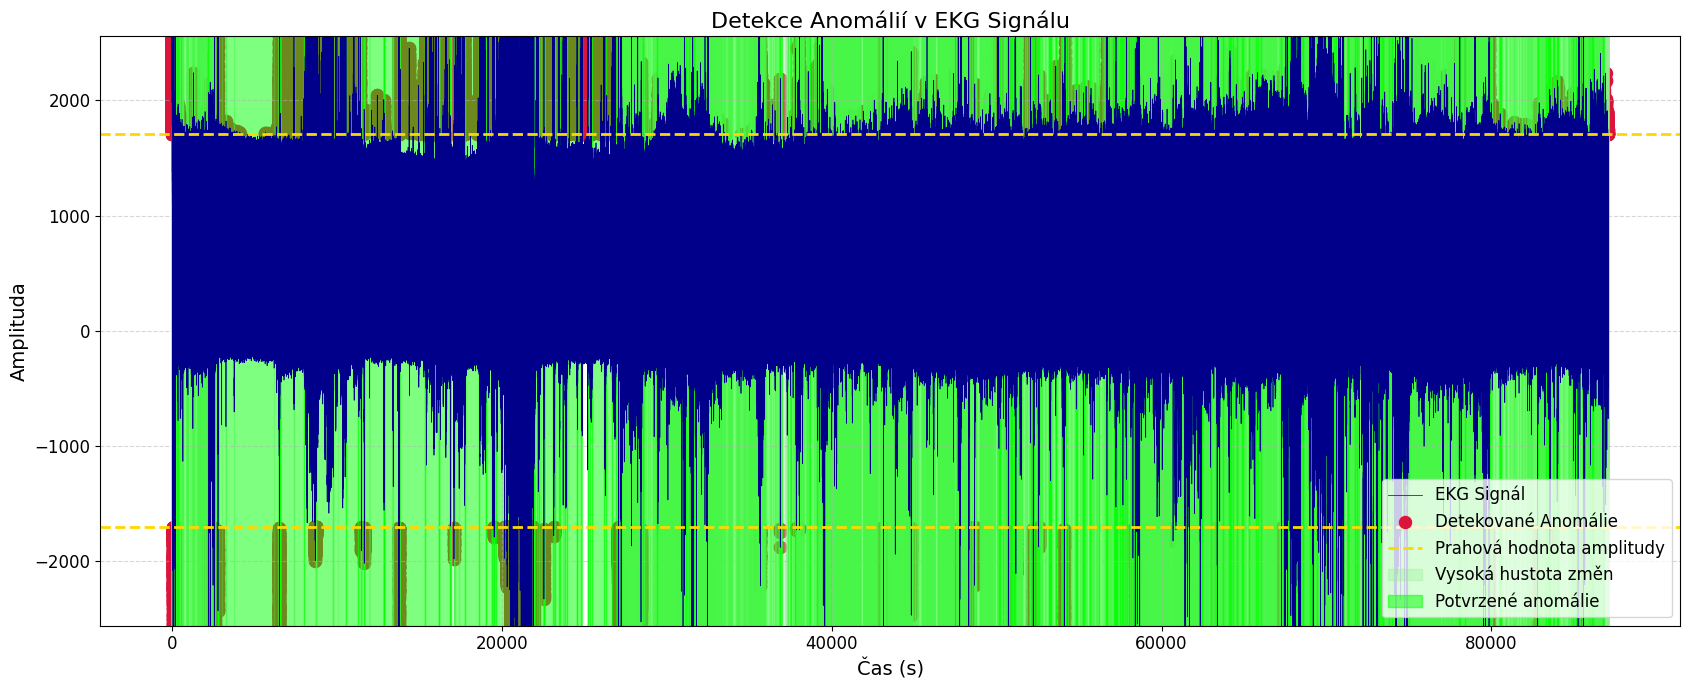

In [10]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detekce_anomalie_amplitudy(signal):
    prumer_amplituda = np.mean(signal)
    std_amplituda = np.std(signal)
    
    # Dynamické prahování
    prah_amplituda = prumer_amplituda + 3.7 * std_amplituda
    anomalie = np.where(np.abs(signal) > prah_amplituda)[0]
    
    return anomalie, prah_amplituda

# Funkce pro výpočet průměrné amplitudy signálu v časových oknech
def vypocet_prumerne_amplitudy(signal, vzorkovaci_frekvence, velikost_okna=1):
    vzorky_na_okno = vzorkovaci_frekvence * velikost_okna
    prumer_amplituda = [np.mean(np.abs(signal[i:i + vzorky_na_okno]))
                        for i in range(0, len(signal), vzorky_na_okno)]
    return np.array(prumer_amplituda)

# Funkce pro detekci hustoty změn signálu
def detekce_hustota_zmen(signal, vzorkovaci_frekvence, velikost_okna=1):
    vzorky_na_okno = vzorkovaci_frekvence * velikost_okna
    hustota = [np.sum(np.abs(np.diff(signal[i:i + vzorky_na_okno])))
               for i in range(0, len(signal), vzorky_na_okno)]
    return np.array(hustota)

# Funkce pro zpracování signálu a porovnání s anotacemi
def zpracovani_signalu(cesta_zaznam, cesta_anotace, vzorkovaci_frekvence=1000):
    try:
        zaznam = wfdb.rdrecord(cesta_zaznam)
        delka_signalu = len(zaznam.p_signal)
        signal = zaznam.p_signal[:, 0]

        # Detekce anomálií na základě amplitudy
        anomalie, prah_amplituda = detekce_anomalie_amplitudy(signal)

        signal -= np.mean(signal)

        anotace = pd.read_csv(cesta_anotace, header=None)
        zacatek_anotace = anotace.iloc[:, 0].values
        konec_anotace = anotace.iloc[:, 1].values

        validni_anotace = (zacatek_anotace < delka_signalu) & (konec_anotace < delka_signalu)
        zacatek_anotace = zacatek_anotace[validni_anotace]
        konec_anotace = konec_anotace[validni_anotace]

        shodne_anotace = sum(1 for zacatek, konec in zip(zacatek_anotace, konec_anotace) if any(zacatek <= anomalie < konec for anomalie in anomalie))
        celkem_anotaci = len(zacatek_anotace)

        pocet_anomalie = len(anomalie)
        uspesnost = shodne_anotace / celkem_anotaci if celkem_anotaci > 0 else 0

        # Výpočet průměrné amplitudy
        prumer_amplituda = vypocet_prumerne_amplitudy(signal, vzorkovaci_frekvence)

        # Detekce hustoty změn signálu
        hustota = detekce_hustota_zmen(signal, vzorkovaci_frekvence)
        prah_hustota = np.percentile(hustota, 75)

        cas = np.arange(len(signal)) / vzorkovaci_frekvence
        plt.figure(figsize=(17, 7))
        plt.plot(cas, signal, label='EKG Signál', color='darkblue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(cas[anomalie], signal[anomalie], color='crimson', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahové hodnoty
        plt.axhline(y=prah_amplituda, color='gold', linestyle='--', linewidth=2, label='Prahová hodnota amplitudy')
        plt.axhline(y=-prah_amplituda, color='gold', linestyle='--', linewidth=2)

        # Zvýraznění hustoty změn
        for i, d in enumerate(hustota):
            if d > prah_hustota:
                plt.axvspan(i, i + 1, color='lightgreen', alpha=0.3, label='Vysoká hustota změn' if i == 0 else None)

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for zacatek, konec in zip(zacatek_anotace, konec_anotace):
            shodne_anomalie = [anomalie for anomalie in anomalie if zacatek <= anomalie < konec]
            if shodne_anomalie:
                plt.axvspan(zacatek / vzorkovaci_frekvence, konec / vzorkovaci_frekvence, color='lime', alpha=0.5, label='Potvrzené anomálie' if zacatek == zacatek_anotace[0] else "")

        plt.ylim(-1.5 * prah_amplituda, 1.5 * prah_amplituda)

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return pocet_anomalie, shodne_anotace, uspesnost

    except Exception as e:
        print(f"Chyba při zpracování {cesta_zaznam}: {e}")
        return 0, 0, 0

cesta_zaznam = 'brno-university-of-technology/100001/100001_ECG'  # Cesta k souboru EKG signálu
cesta_anotace = 'brno-university-of-technology/100001/100001_ANN.csv'  # Cesta k souboru anotací

pocet_anomalie, pocet_shodne, uspesnost = zpracovani_signalu(cesta_zaznam, cesta_anotace)

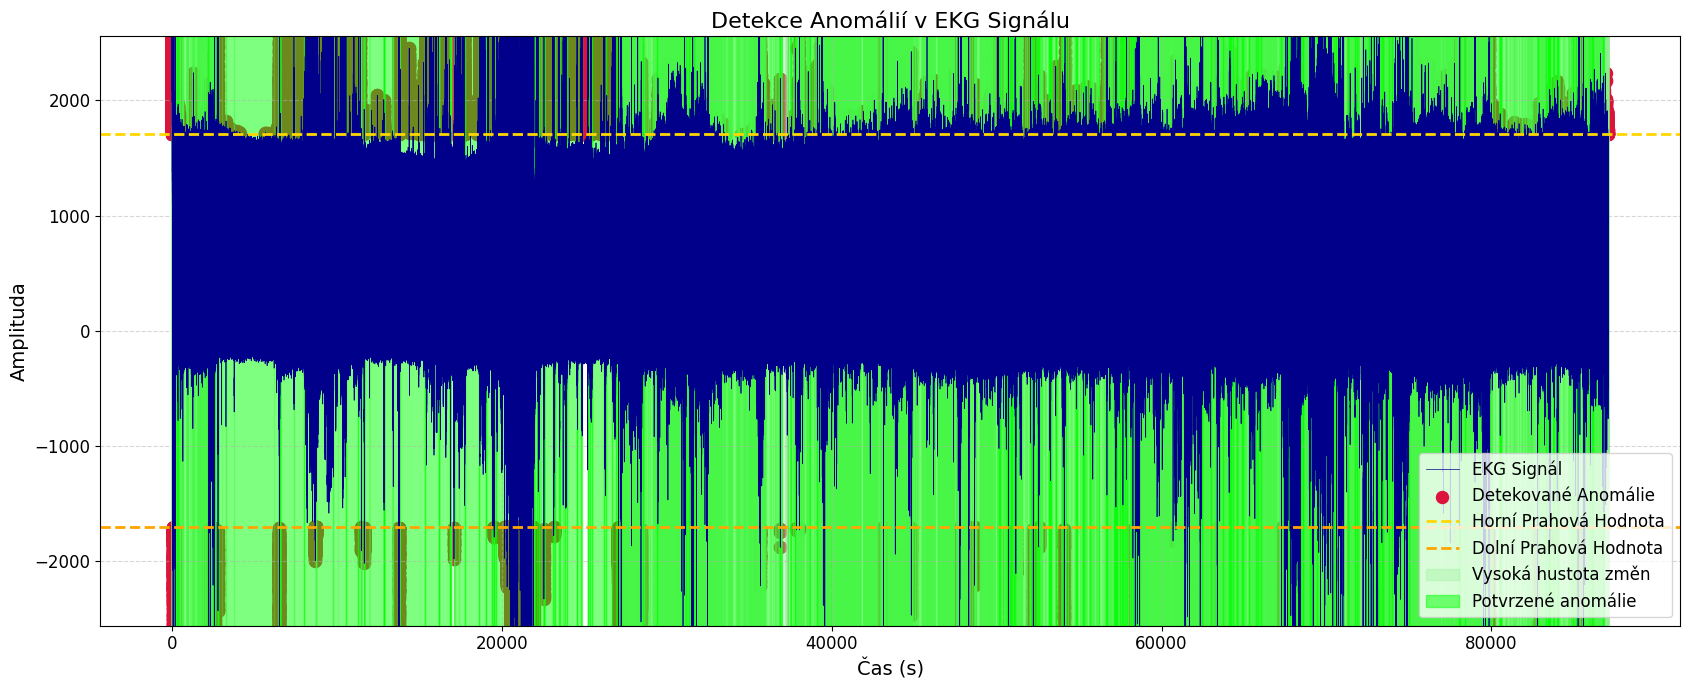

In [12]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy s oddělenými prahy
def detekce_anomalie_amplitudy(signal):
    prumer_amplituda = np.mean(signal)
    std_amplituda = np.std(signal)
    
    # Oddělené dynamické prahové hodnoty
    prah_kladny = prumer_amplituda + 3.7 * std_amplituda
    prah_zaporny = prumer_amplituda - 3.7 * std_amplituda
    
    # Detekce anomálií zvlášť pro kladné a záporné hodnoty
    anomalie_kladne = np.where(signal > prah_kladny)[0]
    anomalie_zaporne = np.where(signal < prah_zaporny)[0]
    
    # Spojení obou sad anomálií
    anomalie = np.concatenate((anomalie_kladne, anomalie_zaporne))
    return anomalie, prah_kladny, prah_zaporny

# Funkce pro výpočet průměrné amplitudy signálu v časových oknech
def vypocet_prumerne_amplitudy(signal, vzorkovaci_frekvence, velikost_okna=1):
    vzorky_na_okno = vzorkovaci_frekvence * velikost_okna
    prumer_amplituda = [np.mean(np.abs(signal[i:i + vzorky_na_okno]))
                        for i in range(0, len(signal), vzorky_na_okno)]
    return np.array(prumer_amplituda)

# Funkce pro detekci hustoty změn signálu
def detekce_hustota_zmen(signal, vzorkovaci_frekvence, velikost_okna=1):
    vzorky_na_okno = vzorkovaci_frekvence * velikost_okna
    hustota = [np.sum(np.abs(np.diff(signal[i:i + vzorky_na_okno])))
               for i in range(0, len(signal), vzorky_na_okno)]
    return np.array(hustota)

# Funkce pro zpracování signálu a porovnání s anotacemi
def zpracovani_signalu(cesta_zaznam, cesta_anotace, vzorkovaci_frekvence=1000):
    try:
        zaznam = wfdb.rdrecord(cesta_zaznam)
        delka_signalu = len(zaznam.p_signal)
        signal = zaznam.p_signal[:, 0]

        # Detekce anomálií na základě amplitudy
        anomalie, prah_kladny, prah_zaporny = detekce_anomalie_amplitudy(signal)

        signal -= np.mean(signal)

        anotace = pd.read_csv(cesta_anotace, header=None)
        zacatek_anotace = anotace.iloc[:, 0].values
        konec_anotace = anotace.iloc[:, 1].values

        validni_anotace = (zacatek_anotace < delka_signalu) & (konec_anotace < delka_signalu)
        zacatek_anotace = zacatek_anotace[validni_anotace]
        konec_anotace = konec_anotace[validni_anotace]

        shodne_anotace = sum(1 for zacatek, konec in zip(zacatek_anotace, konec_anotace) if any(zacatek <= anomalie < konec for anomalie in anomalie))
        celkem_anotaci = len(zacatek_anotace)

        pocet_anomalie = len(anomalie)
        uspesnost = shodne_anotace / celkem_anotaci if celkem_anotaci > 0 else 0

        # Výpočet průměrné amplitudy
        prumer_amplituda = vypocet_prumerne_amplitudy(signal, vzorkovaci_frekvence)

        # Detekce hustoty změn signálu
        hustota = detekce_hustota_zmen(signal, vzorkovaci_frekvence)
        prah_hustota = np.percentile(hustota, 75)

        cas = np.arange(len(signal)) / vzorkovaci_frekvence
        plt.figure(figsize=(17, 7))
        plt.plot(cas, signal, label='EKG Signál', color='darkblue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(cas[anomalie], signal[anomalie], color='crimson', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahových hodnot
        plt.axhline(y=prah_kladny, color='gold', linestyle='--', linewidth=2, label='Horní Prahová Hodnota')
        plt.axhline(y=prah_zaporny, color='orange', linestyle='--', linewidth=2, label='Dolní Prahová Hodnota')

        # Zvýraznění hustoty změn
        for i, d in enumerate(hustota):
            if d > prah_hustota:
                plt.axvspan(i, i + 1, color='lightgreen', alpha=0.3, label='Vysoká hustota změn' if i == 0 else None)

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for zacatek, konec in zip(zacatek_anotace, konec_anotace):
            shodne_anomalie = [anomalie for anomalie in anomalie if zacatek <= anomalie < konec]
            if shodne_anomalie:
                plt.axvspan(zacatek / vzorkovaci_frekvence, konec / vzorkovaci_frekvence, color='lime', alpha=0.5, label='Potvrzené anomálie' if zacatek == zacatek_anotace[0] else "")

        plt.ylim(-1.5 * max(abs(prah_kladny), abs(prah_zaporny)), 1.5 * max(abs(prah_kladny), abs(prah_zaporny)))

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return pocet_anomalie, shodne_anotace, uspesnost

    except Exception as e:
        print(f"Chyba při zpracování {cesta_zaznam}: {e}")
        return 0, 0, 0

cesta_zaznam = 'brno-university-of-technology/100001/100001_ECG'  # Cesta k souboru EKG signálu
cesta_anotace = 'brno-university-of-technology/100001/100001_ANN.csv'  # Cesta k souboru anotací

pocet_anomalie, pocet_shodne, uspesnost = zpracovani_signalu(cesta_zaznam, cesta_anotace)

                Statistika  Hodnota
0  Počet shodných anomálií        0
1    Úspěšnost detekce (%)        0


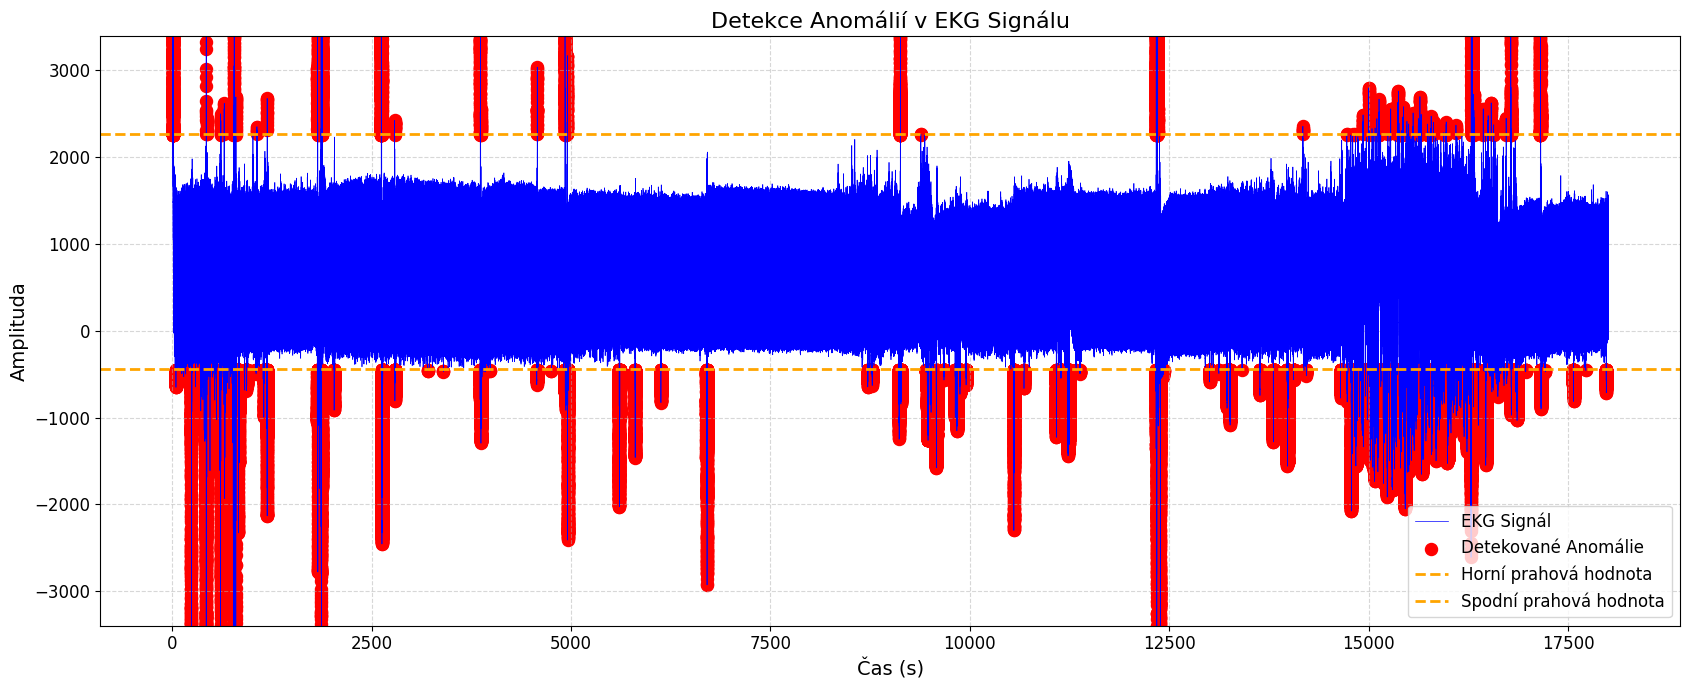

In [15]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detect_anomalies_amplitude(signal):
    mean_amplitude = np.mean(signal)
    std_amplitude = np.std(signal)
    
    # Dynamické prahování
    threshold_upper = mean_amplitude + 3.7 * std_amplitude
    threshold_lower = mean_amplitude - (3.7 * std_amplitude) / 5  # Spodní hranice je 5× blíže k nule

    anomalies = np.where((signal > threshold_upper) | (signal < threshold_lower))[0]
    
    return anomalies, threshold_upper, threshold_lower

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000, duration=18000):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Detekce anomálií na základě amplitudy
        anomalies, threshold_upper, threshold_lower = detect_anomalies_amplitude(signal)

        signal -= np.mean(signal)

        annotations = pd.read_csv(ann_path, header=None)
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < max_samples) & (annotation_end < max_samples)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        # Vytvoření tabulky se statistickými ukazateli
        stats = {
            'Statistika': ['Počet shodných anomálií', 'Úspěšnost detekce (%)'],
            'Hodnota': [matching_annotations, success_rate * 100]
        }
        stats_df = pd.DataFrame(stats)
        print(stats_df)

        time = np.arange(len(signal)) / sampling_rate
        plt.figure(figsize=(17, 7))
        plt.plot(time, signal, label='EKG Signál', color='blue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(time[anomalies], signal[anomalies], color='red', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahových hodnot
        plt.axhline(y=threshold_upper, color='orange', linestyle='--', linewidth=2, label='Horní prahová hodnota')
        plt.axhline(y=threshold_lower, color='orange', linestyle='--', linewidth=2, label='Spodní prahová hodnota')

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for start, end in zip(annotation_start, annotation_end):
            matching_anomalies = [anomaly for anomaly in anomalies if start <= anomaly < end]
            if matching_anomalies:
                plt.axvspan(start / sampling_rate, end / sampling_rate, color='green', alpha=0.5, label='Potvrzené anomálie' if start == annotation_start[0] else "")

        plt.ylim(-1.5 * threshold_upper, 1.5 * threshold_upper)

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'brno-university-of-technology/100002/100002_ECG'  # Cesta k souboru EKG signálu
ann_path = 'brno-university-of-technology/100002/100002_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)

